In [67]:
import torch
from torch import nn

import sys
import os
path = os.path.abspath("Helpers")
sys.path.append(path)
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tqdm.auto import tqdm 

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path/"pizaa_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the data")
    f.write(request.content)
    f.close()

with zipfile.ZipFile(data_path/"pizaa_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi already exists
Unzipping data...


In [70]:
import os

def walk_through_dir(dir_path):
    for dirpath, dirname, filenams in os.walk(dir_path):
        print(f"There are {len(dirname)} directories and {len(filenams)} images in {dirpath}")

walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [71]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [72]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [73]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

In [74]:

# random.seed(42)
random_image_path = random.choice(image_path_list)
# random_image_path
image_class = random_image_path.parent.stem
# print(image_class)
img = Image.open(random_image_path)
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")



Random image path : data\pizza_steak_sushi\train\sushi\3579071.jpg
Image class : sushi
Image height : 512
Image width : 512


(512, 512, 3)


Text(0.5, 1.0, 'sushi')

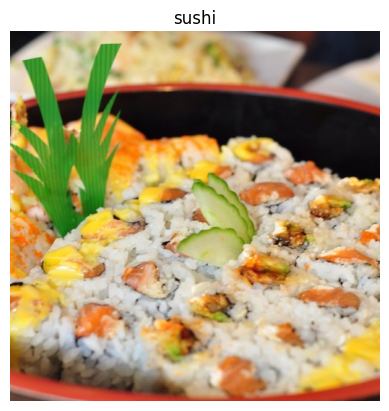

In [75]:
import numpy as np

img_array = np.array(img)
print(img_array.shape)
plt.imshow(img_array)
plt.axis(False)
plt.title(image_class)

In [76]:
print(img_array)

[[[ 16  14  17]
  [ 16  14  17]
  [ 15  13  16]
  ...
  [ 22  22  32]
  [ 22  22  32]
  [ 22  22  32]]

 [[ 16  14  17]
  [ 16  14  17]
  [ 16  14  17]
  ...
  [ 22  22  32]
  [ 22  22  32]
  [ 22  22  32]]

 [[ 16  14  17]
  [ 16  14  17]
  [ 16  14  17]
  ...
  [ 22  22  32]
  [ 22  22  32]
  [ 22  22  32]]

 ...

 [[100  70  59]
  [100  70  59]
  [ 99  70  56]
  ...
  [ 37  22  19]
  [ 37  22  19]
  [ 38  23  20]]

 [[ 99  71  59]
  [ 99  71  59]
  [ 98  70  58]
  ...
  [ 40  22  20]
  [ 40  22  20]
  [ 40  22  20]]

 [[ 96  70  57]
  [ 96  70  57]
  [ 98  70  58]
  ...
  [ 40  22  20]
  [ 41  21  20]
  [ 41  21  20]]]


Transforming Data

In [77]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

tImg = data_transform(img)





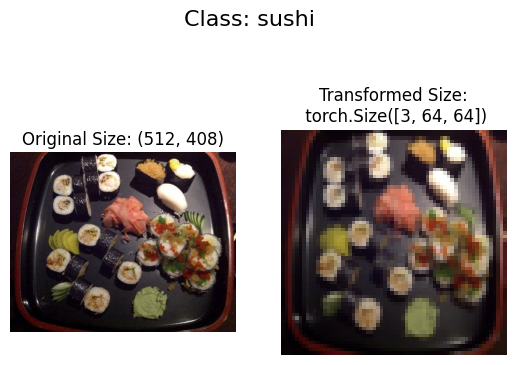

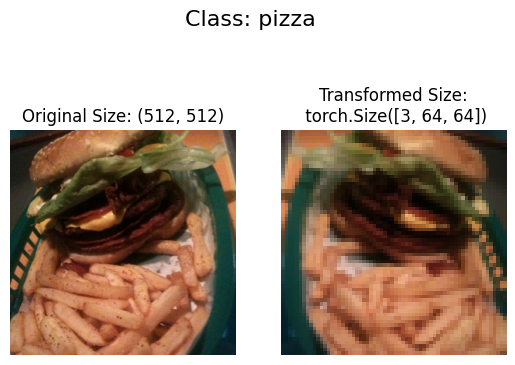

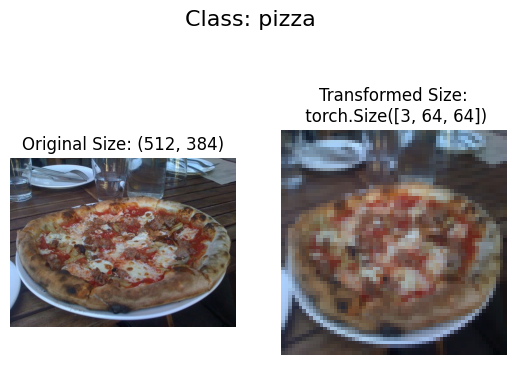

In [78]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size: {f.size}")
            ax[0].axis(False)

            transformed_image = transform(f)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed Size:\n {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_paths=image_path_list, transform=data_transform)


Option 1:


In [79]:
train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform=None)
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

(-0.5, 63.5, 63.5, -0.5)

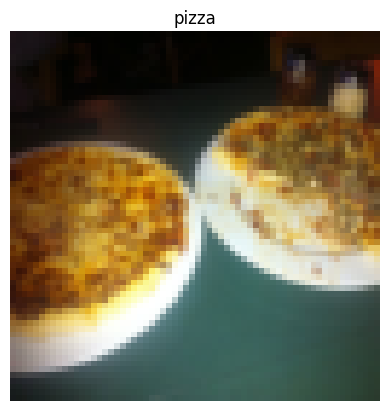

In [80]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict
len(train_data.samples), len(train_data.targets)
img, label = train_data[0][0], train_data[0][1]
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [107]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                               batch_size=BATCH_SIZE,
                               num_workers=1,
                               shuffle=True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE, 
                             num_workers=1,
                             shuffle = False)

In [82]:
print(train_dataloader.dataset[133][1])

1


Option 2:


In [83]:
import os
import pathlib
import torch
from torch.utils.data.dataset import Dataset
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

def findClasses(directory):
    classes = sorted(entry.name for entry in list(os.scandir(directory)))
    
    indexLabel = {val:index for index, val in enumerate(classes)} 
    
    if not classes:
        raise FileNotFoundError(f"Clould not find classes in {directory}... Please check file directory")
    return classes, indexLabel

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir, transform = None):
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Set up transform
        self.transform = transform
        # Create classes and class_to_index attributes
        self.classes, self.class_to_idx = findClasses(targ_dir)

    # Function to load an image by index
    def loadImage(self, idx):
        image_path = self.paths[idx]
        return Image.open(image_path)

    # Overwrite __len__()
    def __len__(self):
        return len(self.paths) 
    
    # Overwrite __getItem__() method to return a particular sample
    def __getitem__(self, index):
        img = self.loadImage(index)
        class_name = self.paths[index].parent.name #Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [84]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [85]:
train_data_custom = ImageFolderCustom(targ_dir = train_dir, transform = train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir, transform = test_transforms) 
train_data.classes == train_data_custom.classes, test_data.class_to_idx == test_data_custom.class_to_idx

(True, True)

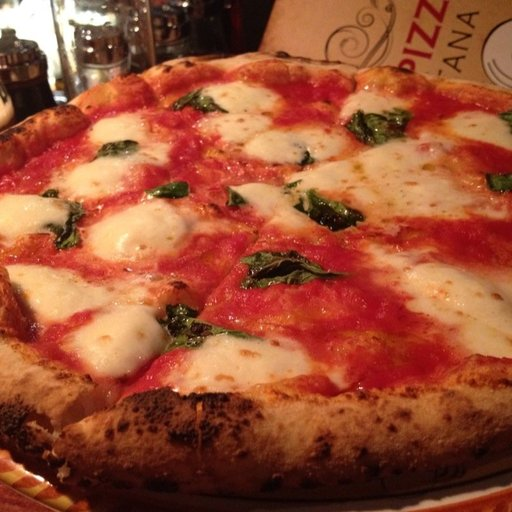

In [86]:
train_data_custom.loadImage(1)

In [87]:
def display_random_images(dataset, classes, n, display_shape = True, seed = None):
    if n > 10:
        display_shape = False
        print(f"For display purposes, n should be less than 11")
    
    if seed:
        see = random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize = (16, 8))
    for i, targ_sample in enumerate(random_sample_idx):
        img, label = dataset[targ_sample]
        img = img.permute(1, 2, 0)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[label]}"
            # if display_shape:
                # title = title + f"\nshape: {img.shape}"
        plt.title(title)
    

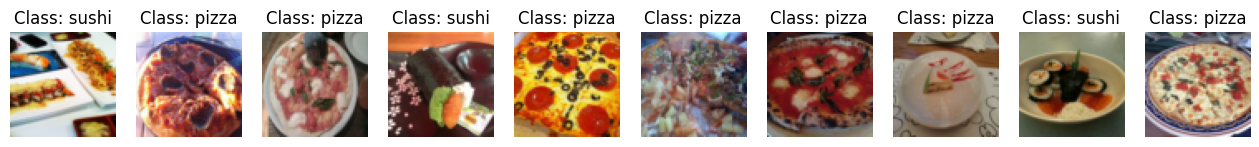

In [88]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=10, 
                      classes=class_names,
                      seed=42)

In [146]:
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                               batch_size=BATCH_SIZE,
                               num_workers=0,
                               shuffle=True,)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                               batch_size=BATCH_SIZE,
                               num_workers=0,
                               shuffle=False)

In [90]:
train_dataloader_custom,test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x1d5e4fdb190>,
 <torch.utils.data.dataloader.DataLoader at 0x1d5e4ea2910>)

In [114]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [134]:
train_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.RandAugment(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor() 
])

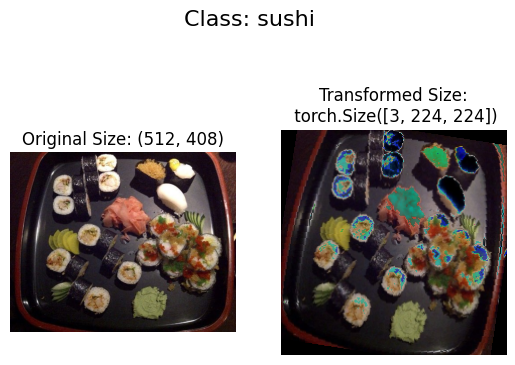

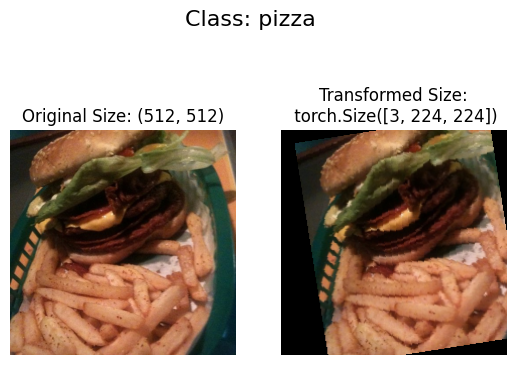

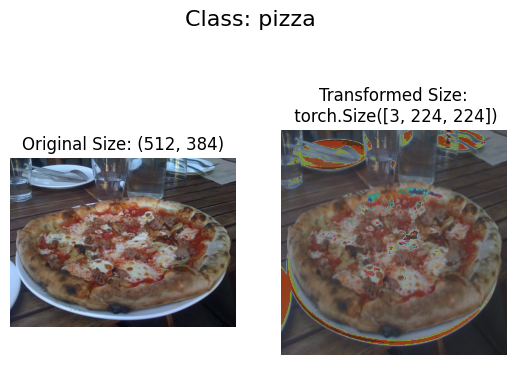

In [144]:
plot_transformed_images(image_paths=image_path_list, transform=train_transforms)

Model without DataAugmentation

In [149]:
simple_tranform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])
train_data_simple = datasets.ImageFolder(
    root = train_dir, 
    transform=simple_tranform
)
test_data_simple = datasets.ImageFolder(
    root = test_dir, 
    transform=simple_tranform
)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader( 
    dataset = train_data_simple,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    shuffle=True    
)
test_dataloader_simple = DataLoader( 
    dataset = train_data_simple,
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS,
    shuffle=False    
)

In [173]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3, 
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2= nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3, 
                stride = 1,
                padding = 1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16, 
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))
        

In [174]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [175]:
image_batch, label_batch = next(iter(train_dataloader_simple))



In [176]:
image_batch = image_batch.to(device)
model_0(image_batch)

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

In [177]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia